In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time

In [ ]:
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [ ]:
for category in range(4):
    images = [img_to_array(load_img(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}/{file}', color_mode='grayscale', target_size=(360, 480))) for file in os.listdir(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}')]

    labels = [category] * len(images)

    train_images_category, test_images_category, train_labels_category, test_labels_category = train_test_split(images, labels, test_size=0.2)

    train_images.extend(train_images_category)
    test_images.extend(test_images_category)
    train_labels.extend(train_labels_category)
    test_labels.extend(test_labels_category)

In [ ]:
x_train = np.array(train_images)
x_test = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [ ]:
print(x_train.shape[1])

360


RESTNET

In [ ]:
start_time = time.time()


In [ ]:
from tensorflow.keras.applications import ResNet152


In [ ]:
x_train = np.array([np.repeat(img, 3, axis=-1) for img in x_train])
x_test = np.array([np.repeat(img, 3, axis=-1) for img in x_test])

In [ ]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))


234698864/234698864 [==============================] - 7s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
resnet_model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])


In [ ]:
resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_resnet = resnet_model.fit(x_train, train_labels, epochs=200, validation_data=(x_test, test_labels))


Epoch 1/200
24/24 [==============================] - 32s 569ms/step - loss: 1.5734 - accuracy: 0.2591 - val_loss: 1.3960 - val_accuracy: 0.3048
Epoch 2/200
24/24 [==============================] - 7s 303ms/step - loss: 1.4254 - accuracy: 0.2618 - val_loss: 1.3539 - val_accuracy: 0.2513
Epoch 3/200
24/24 [==============================] - 8s 327ms/step - loss: 1.3774 - accuracy: 0.3347 - val_loss: 1.3424 - val_accuracy: 0.5348
Epoch 4/200
24/24 [==============================] - 8s 352ms/step - loss: 1.3341 - accuracy: 0.3698 - val_loss: 1.2716 - val_accuracy: 0.5401
Epoch 5/200
24/24 [==============================] - 8s 333ms/step - loss: 1.3673 - accuracy: 0.3590 - val_loss: 1.2979 - val_accuracy: 0.4278
Epoch 6/200
24/24 [==============================] - 8s 353ms/step - loss: 1.2973 - accuracy: 0.4291 - val_loss: 1.3178 - val_accuracy: 0.4171
Epoch 7/200
24/24 [==============================] - 10s 420ms/step - loss: 1.2943 - accuracy: 0.3819 - val_loss: 1.2217 - val_accuracy: 0.49

6/6 [==============================] - 2s 254ms/step - loss: 0.5718 - accuracy: 0.7807


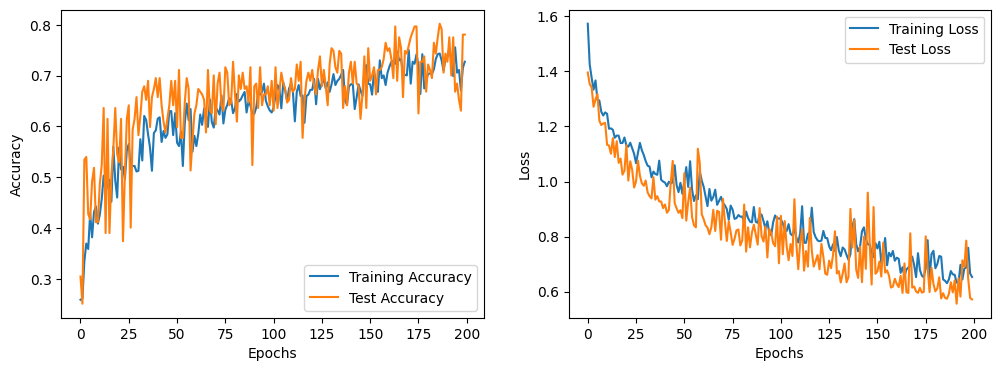

In [ ]:
test_loss, test_acc = resnet_model.evaluate(x_test, test_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
predictions_resnet = resnet_model.predict(x_test)
binary_predictions_resnet = np.argmax(predictions_resnet, axis=1)
test_labels = test_labels.reshape(-1, 1)
# Calculate metrics
conf_matrix_resnet = confusion_matrix(test_labels, binary_predictions_resnet)
accuracy_resnet = np.trace(conf_matrix_resnet) / np.sum(conf_matrix_resnet)
precision_resnet = np.diagonal(conf_matrix_resnet) / np.sum(conf_matrix_resnet, axis=0)
recall_resnet = np.diagonal(conf_matrix_resnet) / np.sum(conf_matrix_resnet, axis=1)
f1_score_resnet = 2 * (precision_resnet * recall_resnet) / (precision_resnet + recall_resnet)

# Specificity
num_classes_resnet = len(conf_matrix_resnet)
specificity_resnet = []
for i in range(num_classes_resnet):
    true_negatives_resnet = np.sum(conf_matrix_resnet) - np.sum(conf_matrix_resnet[i, :]) - np.sum(conf_matrix_resnet[:, i]) + conf_matrix_resnet[i, i]
    false_positives_resnet = np.sum(conf_matrix_resnet[:, i]) - conf_matrix_resnet[i, i]
    specificity_class_resnet = true_negatives_resnet / (true_negatives_resnet + false_positives_resnet)
    specificity_resnet.append(specificity_class_resnet)

average_specificity_resnet = np.mean(specificity_resnet)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_resnet)

# Print the metrics
print(f"Accuracy: {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet}")
print(f"Recall: {recall_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Specificity for each class: {specificity_resnet}")
print(f"Average Specificity: {average_specificity_resnet}")

6/6 [==============================] - 4s 231ms/step
Confusion Matrix:
[[48  0  0  0]
 [ 1 46  0  0]
 [ 3  4  2 26]
 [ 6  1  0 50]]
Accuracy: 0.7807
Precision: [0.82758621 0.90196078 1.         0.65789474]
Recall: [1.         0.9787234  0.05714286 0.87719298]
F1 Score: [0.90566038 0.93877551 0.10810811 0.7518797 ]
Specificity for each class: [0.9280575539568345, 0.9642857142857143, 1.0, 0.8]
Average Specificity: 0.9230858170606373


In [ ]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time} seconds.")

Training took 1757.2458107471466 seconds.
